In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from itertools import product
from tqdm import tqdm

In [2]:
def clean_axes(ax):
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

# MetaKMeans: um ensemble de KMeans

Após ouvir falar superficialmente sobre cômites de algorítmos de clusterização [[1](#bibliography)], me perguntei: qual seria um jeito esperto de agregar as decisões individuais de cada um dos clusters em um valor final? A resposta não é imediatar, principalmente porque o problema aqui é que a definição de cada cluster pode ser diferente mesmo quando eles concordam nas separações.

Por exemplo, dado um conjunto de oito exemplos, as segmentações `[0, 0, 1, 0, 2, 2, 2, 1]` e `[1, 1, 0, 1, 3, 3, 3, 0]` são idênticas a menos de uma permutação de nomes, isto é, basta chamar o cluster 0 de 1 e o 1 de 0 em alguma das listas e o 3 de 2 na segunda lista (ou o 2 de 3 na primeira lista). É importante ter clareza de que esses clusters de fato concordam, uma vez que a nomeclatura não tem significado algum já que não estamos num problema de classificação.

Isso motiva a criação de métricas de "avaliação de clusterização" como a [`sklearn.metrics.rand_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) que responde a pergunta: o quão similar são duas clusterizações? Em que obter o valor próximo de 1 significa que os agrupamentos concordam bastante (a menos de possíveis trocas de nomes).

In [3]:
from sklearn.metrics import rand_score

rand_score([0, 0, 1, 0, 2, 2, 2, 1], [1, 1, 0, 1, 3, 3, 3, 0])

1.0

$\oint$ _A ideia por trás do [(unadjusted) rand index](https://en.wikipedia.org/wiki/Rand_index) é bem intuitiva e para explicar, vamos pensar em um exemplo específico. Imagine o cenário em que temos um conjunto de dados `[a, b, c, d]` e duas clusterizações possíveis: `A = [1, 1, 0, 0]` e `B = [1, 1, 1, 2]`._

1. _Primeiro, separamos todos os pares possíveis de elementos que temos no nosso conjunto. No nosso exemplo teríamos `(a, b)`, `(a, c)`, `(a, d)`, `(b, c)`, `(b, d)` e `(c, d)`._
2. _Em seguida, contabilizamos quantos desses pares concordam nas clusterizações `A` e `B`. Concordar nas clusterizações significa que estão no mesmo cluster ao mesmo tempo tanto em `A` quanto em `B`, ou não estão no mesmo cluster ao mesmo tempo nas duas clusterizações. No nosso caso, o par `(a, b)` concorda porque tanto em `A` quanto em `B` ambos estão no mesmo cluster. Mas também os pares `(a, d)` e `(b, d)` concordam nas duas clusterizações porque são alocados em clusters diferentes simultaneamente._
3. _Com o número de pares concordantes, fazemos a razão pelo número total de pares para ter o valor do unadjusted rand index calculado, nossa medida de similaridade entre agrupamentos. No nosso caso, `3/6=0.5`._

In [4]:
rand_score([1, 1, 0, 0], [1, 1, 1, 2])

0.5

Essas permutações deixam o problema extremamente mais desafiador do que temos num cômite supervisionado e existe uma literatura extensa [[1](#bibliography)] que tenta abordar esse problema uma vez que gostaríamos de poder utilizar ideias de cômites também aqui.

Conversando com o [Alessandro](https://www.linkedin.com/in/atmg92/), tentamos encarar esse problema em uma versão mais compacta dele, analisando o caso específico de cômites de [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (apesar de mais simples, ainda assim seria um caso com possível ganho prático pela popularidade do método). A hipótese seria de que é possível utilizar os centroídes para achar as concordâncias entre os diferentes estimadores individuais e daí surgiu a ideia de clusterizar os centroídes dos [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) individuais para renomear os clusters finais de uma maneira única entre os diferentes estimadores individuais.

Para exemplicar a ideia, um exemplo ajuda: se temos dois [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) com `n_clusters=3`, então teríamos três centróides $K_1, K_2, K_3$ associados ao primeiro [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) e os centróides $C_1, C_2, C_3$ do segundo [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Se, ao clusterizar (com o mesmo número de clusters `n_clusters`, encontrássemos os metaclusters $G_1 = \{ K_1, C_1 \}$, $G_2 = \{ K_2, K_3, C_3\}$ e $G_3 = \{ C_2\}$, então teríamos um mapa na hora de agregar o resultado dos diferentes [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) individuais.

Um exemplo que cai no cluster $K_1$ no primeiro agrupamento e em $C_3$ no segundo é associado ao cluster $G_1$ com peso $0.5$, ao cluster $G_2$ com peso $0.5$ e ao cluster $G_3$ com peso $0$. Já um exemplo que cai em $K_3$ e $C_3$ nos agrupamentos individuais estaria associado ao grupo $G_2$ com peso $1$ enquanto nos outros $G_i$ com peso $0$. Outros casos são análogos. Nesse formato, estamos voltando à mesma ideia de uma votação de um cômite clássico de classificação para criar um indíce de pertencimento de cada exemplo em cada cluster como um algoritmo de [soft clustering](https://en.wikipedia.org/wiki/Fuzzy_clustering).

___

## Testanto a ideia no dataset de dígitos

Para fazer um experimento com esse modelo, vamos brincar com o conjunto de imagens de baixa resolução de dígitos escritos à mão que podemos carregar usando a função [`sklearn.datasets.load_digits`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

In [5]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=9)
X = digits.data
X.shape

(1617, 64)

Para introduzir variância nos clusters individuais e eles não concordarem totalmente (a menos de alguma permutação), podemos tanto mudar a estratégia de treinamento do [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) (por exemplo, diminuindo o número de inicializações que ele faz para encontrar a melhor partição em termos de inercia), quanto fazer um bootstrap do nosso conjunto de treino (inspirado em como um [bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) funciona no caso supervisionado). Nesse experimento, estamos seguindo com a segunda opção.

In [6]:
from sklearn.cluster import KMeans

n_estimators = 250
n_clusters = 9

km_list = \
[KMeans(n_clusters=n_clusters, random_state=i)
 .fit(X[np.random.RandomState(i).choice(X.shape[0], X.shape[0])]) 
 for i in tqdm(range(n_estimators))]

100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


Após treinar os diferentes [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), precisamos treinar o "MetaKMeans" que utilizará os centroídes para treinamento.

In [7]:
cluster_centers = np.vstack([km.cluster_centers_ for km in km_list])

meta_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(cluster_centers)

E daí conseguimos contruir os mapas que agrupam os centroídes fazendo a tradução dos clusters individuais de forma que eles concordem de acordo com o critério de agrupamento do "MetaKMeans".

In [8]:
meta_clusters_map = \
[{j: meta_kmeans.labels_[n_clusters*i+j] for j in range(n_clusters)} for i in range(n_estimators)]

Para fazer o agrupamento dos clusters individuais, fazemos algum tipo de agrupamento (com a média pensando em votação simples) dos diferentes clusters para obter um indíce de pertencimento de cada exemplo a cada cluster.

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer().fit(list(range(n_clusters)))

aggregated_predicts = \
np.array([lb.transform(np.array(list(map(map_dic.get, km.predict(X)))))
          for km, map_dic in zip(km_list, meta_clusters_map)]).mean(axis=0)

aggregated_predicts.shape

(1617, 9)

Para analisar se o que encontramos parece fazer sentido, vamos tentar interpretar os metacentroídes encontrados (ou seja, os centroídes que encontramos quando rodamos o [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) nos centroídes dos [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) base). Como estamos mexendo com essa base de dígitos, podemos olhar para a imagem representada pelo plot do metacentroíde de cada cluster final.

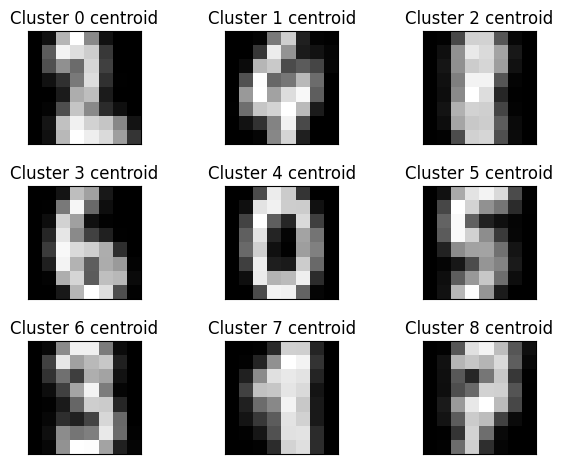

In [10]:
fig, ax = plt.subplots(ncols=3, nrows=3)

plt.gray()
for i, j in product(range(3), range(3)):
    ax[i, j].matshow(meta_kmeans.cluster_centers_[3*i+j].reshape(8, 8))
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    ax[i, j].set_title(f"Cluster {3*i+j} centroid")
plt.tight_layout()

A inspeção visual nos permite dar nomes pros clusters seguindo o formato dos números, construindo o seguinte dicionário:

In [11]:
dict_cluster = {0: 2, 1: 4, 2: 8, 3: 6, 4: 0, 5: 5, 6: 3, 7: 1, 8: 7}

Para ver os clusters finais e em que regiões do espaço estão os nosso pontos associados à cluster incertos, vamos aplicar o [`sklearn.manifold.MDS`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html) para reduzir a dimensionalidade dos nossos dados.

In [12]:
from sklearn.manifold import MDS

X_pca = MDS(random_state=42).fit_transform(X)

É legal ver que nosso clusters estão fazendo sentido com a marcação original de dígitos, mas o gráfico mais importante aqui é o último: vemos que de fato, existem exemplos que parecem ser mais confuso atribuir a algum cluster de forma certa (como as imagens associadas ao número 8 que são facilmente confundidas com outros números e exemplos que parecem estar "na fronteira" entre dois agrupamentos).

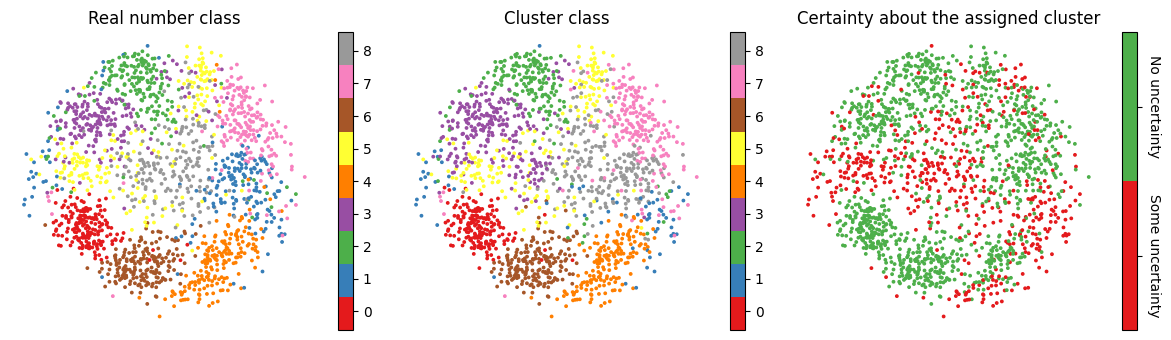

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3.5))

im0 = ax[0].scatter(X_pca[:, 0], X_pca[:, 1], s=3, c=digits.target, cmap='Set1')
cbar0 = plt.colorbar(im0, ax=ax[0], ticks=np.linspace(0.5, 7.5, 9))
cbar0.ax.set_yticklabels(np.arange(0, 9))
ax[0].set_title("Real number class")

im1 = ax[1].scatter(X_pca[:, 0], X_pca[:, 1], s=3,
                    c=list(map(dict_cluster.get, aggregated_predicts.argmax(axis=1))),
                    cmap='Set1')
cbar1 = plt.colorbar(im1, ax=ax[1], ticks=np.linspace(0.5, 7.5, 9))
cbar1.ax.set_yticklabels(np.arange(0, 9))
ax[1].set_title("Cluster class")

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
im2 = ax[2].scatter(X_pca[:, 0], X_pca[:, 1], s=3,
                    c=(aggregated_predicts.max(axis=1)==1).astype(int), cmap=cmap)
im2.set_clim(0, 1)
cbar2 = plt.colorbar(im2, ax=ax[2], ticks=[0.25, 0.75])
cbar2.ax.set_yticklabels(['Some uncertainty', 'No uncertainty'],
                         rotation=270, ha='center', rotation_mode="anchor")
cbar2.ax.tick_params(pad=10)
ax[2].set_title("Certainty about the assigned cluster")

for axs in ax:
    clean_axes(axs)
plt.tight_layout()

Vendo o histograma do máximo do nosso "`.predict_proba`", vemos que para um número razoável de exemplos, os cluster encontrados pelos agrupamentos individuais podem discordar ligeiramente gerando uma visão de incerteza e robustez associada à sua atribuição de agrupamento (ideia central dos algoritmos de [soft clustering](https://en.wikipedia.org/wiki/Fuzzy_clustering)).. 

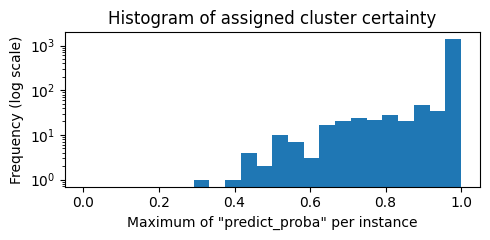

In [14]:
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.hist(aggregated_predicts.max(axis=1), bins=np.linspace(0, 1, 25))
ax.set_yscale("log")
ax.set_xlabel('Maximum of "predict_proba" per instance')
ax.set_ylabel("Frequency (log scale)")
ax.set_title("Histogram of assigned cluster certainty")
plt.tight_layout()

Essa visão nos permite ver os exemplos mais díficies de agrupar, dando uma noção de [instance hardness](https://deslib.readthedocs.io/en/latest/modules/util/instance_hardness.html) para o nosso problema de clusterização, que no nosso exemplo parece estar associado a números parecidos com o 8.

In [15]:
(pd.DataFrame(aggregated_predicts)[(aggregated_predicts<0.45).all(axis=1)]
 .rename(columns=dict_cluster).T.sort_index().T)

,0,1,2,3,4,5,6,7,8
630,0.0,0.084,0.06,0.408,0.0,0.000,0.000,0.000,0.448
1385,0.0,0.204,0.00,0.164,0.0,0.196,0.000,0.424,0.012
1386,0.0,0.088,0.00,0.060,0.0,0.228,0.000,0.312,0.312
1533,0.0,0.076,0.00,0.388,0.0,0.000,0.196,0.000,0.340
1616,0.0,0.032,0.00,0.420,0.0,0.000,0.308,0.000,0.240


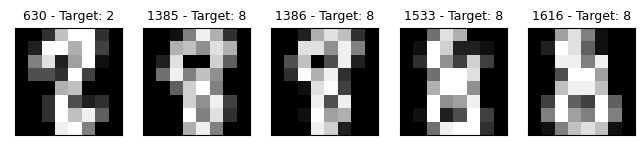

In [16]:
fig, ax = plt.subplots(ncols=5, figsize=(8, 3.5))

plt.gray()
for axs, i in zip(ax, pd.DataFrame(aggregated_predicts)[(aggregated_predicts<0.45).all(axis=1)].index):
    axs.matshow(X[i].reshape(8,8))
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_title(f"{i} - Target: {digits.target[i]}", fontsize=9)
plt.show()

___

## Considerações finais

Essa ideia de clusterização de centroídes não é nova e, inclusive pode ser utilizada para definir a inicialização do KMeans. Esse algoritmo é chamado Refined K-Means [[1](#bibliography)], entretanto não parece ter uma vantagem clara quando comparado com o [K-Means++](https://en.wikipedia.org/wiki/K-means%2B%2B) com multiplas inicializações (maneira que o [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) segue).

Apesar de claramente ter aplicações em que vale a pena testar essa visão, nos experimentos feitos para construir essa discussão, os clusters encontrados individualmente, raramente discordam muito (conseguimos ver isso pelo número significativo de exemplos com `aggregated_predicts.max(axis=1)` sendo igual a 1) e os hard clusters encontrados no final da nossa estratégia de soft cluster (pegando o `.argmax`) são muito parecidos com os cluster encontrados em um KMeans usual.  Portanto, não acho que seja uma técnica extremamente promissora, apesar de valer o teste sempre que você estiver interessado em um KMeans pelo baixo esforço adicional.



In [17]:
unique_km_labels = KMeans(random_state=42).fit(X).labels_

(rand_score(unique_km_labels, aggregated_predicts.argmax(axis=1)),
 (aggregated_predicts.max(axis=1)==1).mean())

(0.9799745280650514, 0.6951144094001237)

___

## Implentação grosseira da classe do estimador

Se você estiver interessado em utilizar essas ideias, ela deveria funcionar utilizando algo na linha da classe implementada a seguir que é compátivel com bibliotecas que sigam o [padrão de código do scikit-learn](https://scikit-learn.org/stable/developers/develop.html). Apenas fique atento ao caso em que `n_clusters==2` pois o `sklearn.preprocessing.LabelBinarizer` mantém apenas uma coluna ao invés de criar duas e nesse caso o return do seu `.predict_proba` terá apenas uma dimensão.

In [18]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer

class MetaKMeans(BaseEstimator):
    """K-Means clustering.

    Parameters
    ----------
    n_clusters : int, default=8
        The number of clusters to form as well as the number of
        metacentroids to generate.

    n_estimators : int, default=100
        The number of k-means in the ensemble.

    random_state : int, default=42
        Controls both the randomness of the bootstrapping of the samples used
        when building the individual k-means and the randomness of the
        choice of initial centroids of each k-means.

    KMeans_params : dict, default={}
        Explicitly set some of the base k-means parameters as **KMeans_params.
    """
    
    def __init__(self, n_clusters=8, n_estimators=100, random_state=42, KMeans_params={}):
        self.n_clusters = n_clusters
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.KMeans_params = KMeans_params

    def fit(self, X, y=None):
        self.estimators_ = \
        [KMeans(n_clusters=self.n_clusters, random_state=i+self.random_state, **self.KMeans_params)
         .fit(X[np.random.RandomState(i).choice(X.shape[0], X.shape[0])]) 
         for i in range(self.n_estimators)]
        
        cluster_centers = np.vstack([km.cluster_centers_ for km in self.estimators_])

        self.meta_kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42).fit(cluster_centers)
        
        self.metacluster_centers_ = self.meta_kmeans_.cluster_centers_
        
        self.meta_clusters_map_ = \
        [{j: self.meta_kmeans_.labels_[self.n_clusters*i+j] for j in range(self.n_clusters)} for i in range(self.n_estimators)]
        
        self.lb_ = LabelBinarizer().fit(list(range(self.n_clusters)))
        
        return self
    
    def predict_proba(self, X):
        return \
        np.array([self.lb_.transform(np.array(list(map(map_dic.get, km.predict(X)))))
                  for km, map_dic in zip(self.estimators_, self.meta_clusters_map_)]).mean(axis=0)
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

In [19]:
class_meta_kmeans_with_params = \
MetaKMeans(n_clusters=9, n_estimators=10, random_state=0, KMeans_params={"init": "random"}).fit(X)

class_meta_kmeans = \
MetaKMeans(n_clusters=9, n_estimators=250, random_state=0).fit(X)
class_predict_probas = class_meta_kmeans.predict_proba(X)

# As I'm choosing the same random_state, I expect results of the class
# to match the ones we did above.
((class_predict_probas == aggregated_predicts).all(),
 (class_meta_kmeans.predict(X) == aggregated_predicts.argmax(axis=1)).all())

(True, True)

## <a name="bibliography">Referências</a>

[1] [Cluster ensembles: A survey of approaches with recent extensions and applications. Tossapon Boongoen Natthakan Iam-On. Computer Science Review Volume 28, 2018.](https://www.sciencedirect.com/science/article/abs/pii/S1574013717300692)